<a href="https://colab.research.google.com/github/signofcommunication/Tugas-Matana-University/blob/master/Lipstick_Enhancement_Fiola_Arta_Gloria_Saranani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install mediapipe opencv-python matplotlib numpy

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Upload gambar wajah (format JPG/PNG):


Saving P6200383.JPG to P6200383.JPG
Warna bibir dominan (HSV mean): [12.98848331 77.82744486 99.73225324]
Rekomendasi lipstik: Light Pink


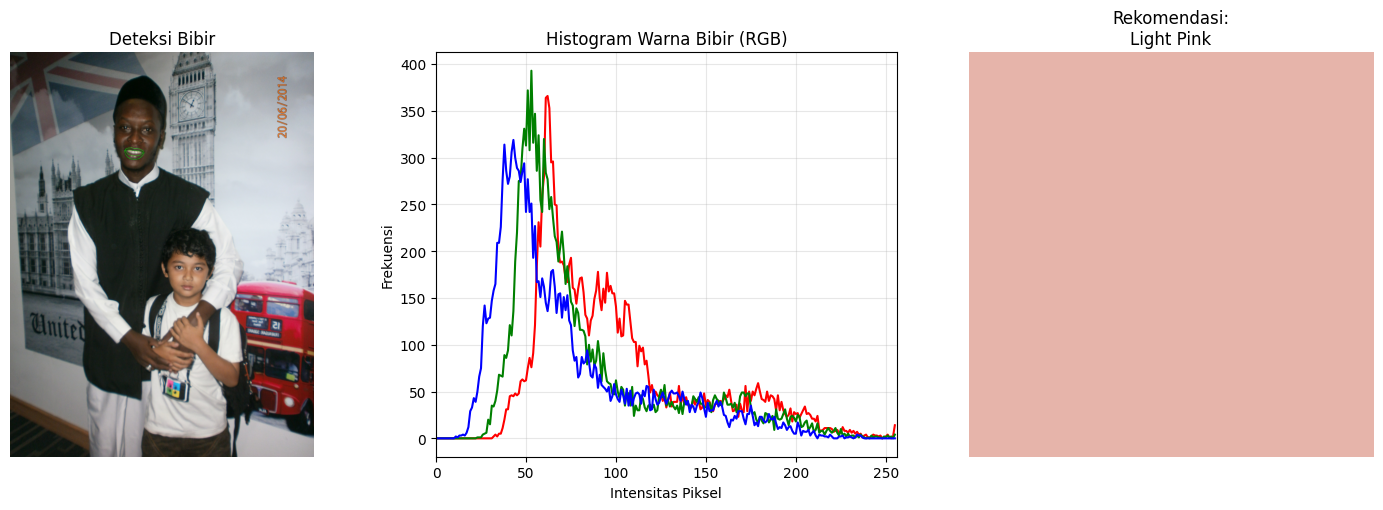

In [21]:
# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

# Define lip landmarks indices (Outer and Inner lips merged for convex hull usually covers the whole mouth area including teeth if open, but good enough for general approximation)
LIP_LANDMARKS = [
    61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 409, 270, 269, 267, 0, 37, 39, 40, 185, # Outer
    78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 415, 310, 311, 312, 13, 82, 81, 80, 191  # Inner
]

# Function to extract lip region and compute dominant color in HSV
def analyze_lip_color(image):
    # Convert to RGB for Mediapipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process with Face Mesh
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        raise ValueError("No face detected in the image.")

    face_landmarks = results.multi_face_landmarks[0]

    # Get image dimensions
    height, width, _ = image.shape

    # Extract lip landmarks points
    lip_points = []
    for idx in LIP_LANDMARKS:
        lm = face_landmarks.landmark[idx]
        x = int(lm.x * width)
        y = int(lm.y * height)
        lip_points.append((x, y))

    # Create a mask for the lip region
    lip_mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillConvexPoly(lip_mask, np.array(lip_points), 255)

    # Extract lip region using the mask
    lip_region = cv2.bitwise_and(image, image, mask=lip_mask)

    # Convert to HSV for analysis
    lip_hsv = cv2.cvtColor(lip_region, cv2.COLOR_BGR2HSV)

    # Compute mean HSV values (ignoring black pixels where mask is 0)
    non_zero_pixels = lip_hsv[lip_mask > 0]
    if len(non_zero_pixels) == 0:
        raise ValueError("No valid lip pixels found.")

    mean_hsv = np.mean(non_zero_pixels, axis=0)

    # Return mask as well for histogram calculation later
    return mean_hsv, lip_points, lip_mask

# Updated Rules-Based System (Nama & Warna Tetap, Logika Diperbaiki)
lipstick_rules = {
    # 1. Dark Brown
    # KONDISI: Jika bibir terdeteksi gelap/kurang cahaya (Value < 90).
    # COCOK UNTUK: Gambar dengan pencahayaan rendah atau bibir gelap.
    'dark_brown': {
        'condition': lambda hsv: hsv[2] < 90,
        'recommendation': 'Dark Brown',
        'color': (103, 115, 197)
    },

    # 2. Light Pink
    # KONDISI: Jika bibir terlihat pucat/kurang merah (Saturation < 100).
    # COCOK UNTUK: Gambar 3 (Pria jarak jauh) atau bibir yang pucat.
    'light_pink': {
        'condition': lambda hsv: hsv[1] < 100,
        'recommendation': 'Light Pink',
        'color': (170, 180, 230)
    },

    # 3. Bright Pink
    # KONDISI: Jika bibir sangat merah/kontras tinggi (Saturation > 145).
    # COCOK UNTUK: Bibir yang sangat merah merona atau pakai lip tint.
    'bright_pink': {
        'condition': lambda hsv: hsv[1] > 145,
        'recommendation': 'Bright Pink',
        'color': (180, 105, 255)
    },

    # 4. Baby Pink (Fallback / Default)
    # KONDISI: Di antara Pucat dan Sangat Merah (Saturation 100 - 145).
    # COCOK UNTUK: Gambar 1, 2, dan 4 (Bibir normal/sehat).
    'baby_pink': {
        'condition': lambda hsv: True, # Selalu True jika kondisi di atas tidak terpenuhi
        'recommendation': 'Baby Pink',
        'color': (255, 182, 193)
    }
}

# Fungsi rekomendasi (Tidak perlu diubah, hanya memastikan urutan pengecekan)
def get_lipstick_recommendation(mean_hsv):
    print(f"[DEBUG] Nilai HSV Terdeteksi: H={mean_hsv[0]:.1f}, S={mean_hsv[1]:.1f}, V={mean_hsv[2]:.1f}")

    # Cek Dark Brown dulu (Prioritas Kecerahan)
    if lipstick_rules['dark_brown']['condition'](mean_hsv):
        return lipstick_rules['dark_brown']['recommendation'], lipstick_rules['dark_brown']['color']

    # Cek Light Pink (Prioritas Pucat)
    if lipstick_rules['light_pink']['condition'](mean_hsv):
        return lipstick_rules['light_pink']['recommendation'], lipstick_rules['light_pink']['color']

    # Cek Bright Pink (Prioritas Merona)
    if lipstick_rules['bright_pink']['condition'](mean_hsv):
        return lipstick_rules['bright_pink']['recommendation'], lipstick_rules['bright_pink']['color']

    # Sisanya masuk Baby Pink (Normal)
    return lipstick_rules['baby_pink']['recommendation'], lipstick_rules['baby_pink']['color']

def get_lipstick_recommendation(mean_hsv):
    for key, rule in lipstick_rules.items():
        if rule['condition'](mean_hsv):
            return rule['recommendation'], rule['color']
    return lipstick_rules['baby_pink']['recommendation'], lipstick_rules['baby_pink']['color']

def draw_lip_detection(image, lip_points):
    image_copy = image.copy()
    cv2.polylines(image_copy, [np.array(lip_points)], isClosed=True, color=(0, 255, 0), thickness=2)
    return image_copy

# Main execution
def main():
    print("Upload gambar wajah (format JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("Tidak ada gambar yang diupload.")
        return

    file_name = next(iter(uploaded))
    image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)

    try:
        # Analyze lip color (now returns mask too)
        mean_hsv, lip_points, lip_mask = analyze_lip_color(image)
        print(f"Warna bibir dominan (HSV mean): {mean_hsv}")

        recommendation, color_rgb = get_lipstick_recommendation(mean_hsv)
        print(f"Rekomendasi lipstik: {recommendation}")

        detected_image = draw_lip_detection(image, lip_points)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Original image in RGB for histogram

        # --- PLOTTING ---
        plt.figure(figsize=(15, 5)) # Diperlebar untuk 3 panel

        # 1. Gambar Bibir Terdeteksi
        plt.subplot(1, 3, 1)
        plt.title("Deteksi Bibir")
        plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # 2. Histogram Warna Bibir
        plt.subplot(1, 3, 2)
        plt.title("Histogram Warna Bibir (RGB)")
        colors = ('r', 'g', 'b')
        # Loop over RGB channels
        for i, color in enumerate(colors):
            # Calculate hist only where mask is present
            hist = cv2.calcHist([image_rgb], [i], lip_mask, [256], [0, 256])
            plt.plot(hist, color=color)
        plt.xlim([0, 256])
        plt.xlabel("Intensitas Piksel")
        plt.ylabel("Frekuensi")
        plt.grid(alpha=0.3)

        # 3. Rekomendasi Warna
        color_swatch = np.zeros((100, 100, 3), dtype=np.uint8)
        color_swatch[:] = color_rgb
        plt.subplot(1, 3, 3)
        plt.title(f"Rekomendasi:\n{recommendation}")
        plt.imshow(cv2.cvtColor(color_swatch, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Error: {e}")

main()